# Performance Predictor (PP) test metamodels with unique features

Test different meta-models

- Run metamodels with various pointwise features.

In this notebook, we will do the following
- Start with the WebOfScience dataset
  - Use the 90 classes with the highest class accuracy size
    - 90 classes deteremined in notebook:
      - 'WebOfScience - filter accuracy ordered classes to 0.80 acc and 90 classes.ipynb'
  - Randomize the dataset.
    - Train set is first 4,500 examples in randomized dataset.
      - Mimics the size of the representative workspace
    - Remaining 29,120 can be used to fit PP.
    - Create base SVC model with the train set.
- Run the basic PP ShortTextClassificationWrapper varying the PP metamodels considered.
  - metamodels_considered = [['svm', 'gbm', 'mlp'], ['svm'], ['gbm'], ['mlp']]
- Results
  - Gather the y_pred and y_score
  - Display the SVC and PP accuracies as well as TH/TL/FH/FL for each run

In [1]:
import gzip
from IPython.display import display, HTML
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.utils import shuffle
import time
from typing import List

from uq360.algorithms.blackbox_metamodel.short_text_classification import ShortTextClassificationWrapper

os.environ["PYTHONWARNINGS"] = 'ignore'

pd.options.display.max_colwidth = 100

%load_ext autoreload
%autoreload 2

# Increase the width of the notebook so that it is the width of the browser 
# which allows larger size for the dashboard
display(HTML('<style>.container { width:100% !important; }</style>'))

2022-08-11 13:01:11.482972: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 13:01:11.483120: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Load workspace dataset

In [2]:
%%time
# X is input data that include text sequences 
# Y is target value 
# YL1 is target value of level one (parent label)
# YL2 is target value of level one (child label)
x_gzip_file = '../../../data/WebOfScience/WebOfScience/WOS46985/X.txt.gzip'
y_file = '../../../data/WebOfScience/WebOfScience/WOS46985/Y.txt'
yl1_file = '../../../data/WebOfScience/WebOfScience/WOS46985/YL1.txt'
yl2_file = '../../../data/WebOfScience/WebOfScience/WOS46985/YL2.txt'

with gzip.open(x_gzip_file, 'rt') as f:
    lines = f.readlines()
df_x = pd.DataFrame(lines, columns=['example'])
df_y = pd.read_csv(y_file, header=None, names=['intent'])
df_yl1 = pd.read_csv(yl1_file, header=None, names=['yl1'])
df_yl2 = pd.read_csv(yl2_file, header=None, names=['yl2'])
data = [{'intent': 'y', 
         'n unique': len(np.unique(df_y['intent'])),
         'min n uniq': min(np.unique(df_y['intent'], return_counts=True)[1]),
         'max n uniq': max(np.unique(df_y['intent'], return_counts=True)[1])
        },
        {'intent': 'yl1', 
         'n unique': len(np.unique(df_yl1['yl1'])),
         'min n uniq': min(np.unique(df_yl1['yl1'], return_counts=True)[1]),
         'max n uniq': max(np.unique(df_yl1['yl1'], return_counts=True)[1])
        }
]
display(HTML(pd.DataFrame(data).to_html()))

df_merge = pd.concat([df_x, df_y], axis=1, sort=False)
print(f'df_merge.shape = {df_merge.shape}')

x = df_merge['example'].to_numpy()
y = df_merge['intent'].to_numpy().ravel()
print(f'x.shape        = {x.shape}')
print(f'y.shape        = {y.shape}')

# display(HTML(df_merge.head(4).to_html()))

,intent,n unique,min n uniq,max n uniq
0,y,134,43,750
1,yl1,7,3297,14625


df_merge.shape = (46985, 2)
x.shape        = (46985,)
y.shape        = (46985,)
CPU times: user 216 ms, sys: 50.8 ms, total: 267 ms
Wall time: 272 ms


#### Encode with USE encoder

In [3]:
%%time
class MiniLMEmbedding:
    def __init__(self):
        self.transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    def encode(self, input_sentences: List[str]) -> np.array:
        sentences = [sentence.lower() for sentence in input_sentences]
        embedded_sentences = [self.embed_sentence(s) for s in sentences]
        return np.array(embedded_sentences)
    def embed_sentence(self, sentence: str) -> np.array:
        embedding = self.transformer.encode(sentence, show_progress_bar=False, convert_to_numpy=True)
        return embedding

encoded_file = '../../../data/WebOfScience/WebOfScience/WOS46985/X_encoded.csv'
if os.path.exists(encoded_file):
    df = pd.read_csv(encoded_file, header=None)
    x_encoded = df.to_numpy()
else:
    encoder = MiniLMEmbedding()
    x_encoded = encoder.encode(x)
    # Save to file
    df = pd.DataFrame(x_encoded)
    df.to_csv(encoded_file, header=False, index=False)

print(f'x_encoded.shape = {x_encoded.shape}')

x_encoded.shape = (46985, 384)
CPU times: user 5.26 s, sys: 296 ms, total: 5.56 s
Wall time: 5.56 s


#### Determine subset datasert for running experiment
- keep_intents is generated in notebook:
  - 'WebOfScience - filter accuracy ordered classes to 0.80 acc and 90 classes.ipynb'

In [4]:
keep_intents = [64, 122, 12, 113, 62, 49, 66, 2, 68, 45, 103, 97, 70, 48, 115, 98, 3, 57, 61, 8, 74, 47, 127, 112, 65, 31, 99, 9, 79, 114, 35, 63, 111, 94, 101, 92, 46, 100, 69, 93, 96, 42, 25, 60, 39, 106, 121, 44, 33, 109, 14, 130, 81, 53, 17, 58, 71, 132, 80, 0, 83, 37, 55, 90, 85, 32, 75, 105, 22, 38, 56, 41, 128, 5, 21, 84, 43, 54, 36, 77, 27, 131, 72, 73, 118, 7, 108, 23, 26, 124]
print(f'len(keep_intents) = {len(keep_intents)}')
print(f'keep_intents = {list(keep_intents)}')
# Gather the example indices for the examples to keep
keep_indices = [i for i in range(len(y)) if y[i] in keep_intents]
print(f'len(keep_indices) = {len(keep_indices)}')
y_sub = y[keep_indices]
x_sub_encoded = x_encoded[keep_indices]
print(f'y_sub.shape         = {y_sub.shape}')
print(f'x_sub_encoded.shape = {x_sub_encoded.shape}')

len(keep_intents) = 90
keep_intents = [64, 122, 12, 113, 62, 49, 66, 2, 68, 45, 103, 97, 70, 48, 115, 98, 3, 57, 61, 8, 74, 47, 127, 112, 65, 31, 99, 9, 79, 114, 35, 63, 111, 94, 101, 92, 46, 100, 69, 93, 96, 42, 25, 60, 39, 106, 121, 44, 33, 109, 14, 130, 81, 53, 17, 58, 71, 132, 80, 0, 83, 37, 55, 90, 85, 32, 75, 105, 22, 38, 56, 41, 128, 5, 21, 84, 43, 54, 36, 77, 27, 131, 72, 73, 118, 7, 108, 23, 26, 124]
len(keep_indices) = 33620
y_sub.shape         = (33620,)
x_sub_encoded.shape = (33620, 384)


#### Randomize the dataset
- Train set is first 4,500 examples in randomized dataset.
  - Mimics the size of the representative workspace
- Remaining 9000 can be used to fit PP.

In [5]:
x, y = shuffle(x_sub_encoded, y_sub, random_state=42)
print(f'y_sub.shape         = {y_sub.shape}')
print(f'x_sub_encoded.shape = {x_sub_encoded.shape}')
print(f'y.shape             = {y.shape}')
print(f'x.shape             = {x.shape}')

train_size = 4500
# train_size = 200
x_train = x[:train_size]
y_train = y[:train_size]
x_test = x[- (len(y) - train_size):]
y_test = y[- (len(y) - train_size):]
print(f'y_train.shape = {y_train.shape}')
print(f'x_train.shape = {x_train.shape}')
print(f'y_test.shape  = {y_test.shape}')
print(f'x_test.shape  = {x_test.shape}')

y_sub.shape         = (33620,)
x_sub_encoded.shape = (33620, 384)
y.shape             = (33620,)
x.shape             = (33620, 384)
y_train.shape = (4500,)
x_train.shape = (4500, 384)
y_test.shape  = (29120,)
x_test.shape  = (29120, 384)


#### Fit a basic SVM classifier

In [6]:
%%time
def train_model_svm(x, y):
    model = SVC(probability=True)
    model.fit(x, y)    
    return model

model = train_model_svm(x_train, y_train)

CPU times: user 38.3 s, sys: 65.8 ms, total: 38.4 s
Wall time: 38.4 s


#### Fit the Performance Predictor

In [7]:
%%time
standard_features = ['confidence_top', 'confidence_delta', 'confidence_entropy', 
                          'class_frequency', 'mlp', 'svc',
                          'predicted_class', 'one_class_svm', 'pca']

original_features = ['original_features']

# first set of tests 2022-07-26
# svm_pointwise_features = original_features
gbm_pointwise_features = standard_features
mlp_pointwise_features_options = [standard_features,
                                  original_features,
                                  original_features + standard_features
                                 ]

# Second set of tests 2022-07-27
# gbm_pointwise_features = standard_features  # Same 
lr_pointwise_features = standard_features
# mlp_pointwise_features_options = [standard_features]
svm_pointwise_features_options = [original_features,
                                  original_features + standard_features,
                                  standard_features]


size = 2000
# size = 50
x_tst = x_test[:size]
y_tst = y_test[:size]

x_prod = x_test[size:size * 2]
y_prod = y_test[size:size * 2]

start = time.time()
svc_test_pred = model.predict(x_tst)
print(f'test dur={time.time() - start} - svc_predict')

start = time.time()
svc_prod_pred = model.predict(x_prod)
print(f'prod dur={time.time() - start} - svc_predict')

experiments = []
for mlp_pointwise_features in mlp_pointwise_features_options:
    for svm_pointwise_features in svm_pointwise_features_options:

        metamodels_considered = {'svm': svm_pointwise_features,
                                 'gbm': gbm_pointwise_features,
                                 'mlp': mlp_pointwise_features,
                                 'lr': lr_pointwise_features}
        pp = ShortTextClassificationWrapper(base_model=model, 
                                            metamodels_considered=metamodels_considered,
                                            calibrator='isotonic_regression')

        # fit PP
        start = time.time()
        pp.fit(x_train, y_train, x_tst, y_tst)
        print(f'dur={time.time() - start} - pp_fitted')
        fit_dur = time.time() - start

        start = time.time()
        pp_test_accuracy, _, pp_test_score = pp.predict(x_tst)
        print(f'test dur={time.time() - start} - pp_test_accuracy  = {pp_test_accuracy / 100}')
        predict_dur = time.time() - start

        experiments.append({'mlp_pointwise_features': mlp_pointwise_features,
                            'svm_pointwise_features': svm_pointwise_features,
                            'dataset': 'test',
                            'y': y_tst,
                            'fit_dur': fit_dur,
                            'predict_dur': predict_dur,
                            'svc_pred': svc_test_pred,
                            'pp_accuracy': pp_test_accuracy / 100,
                            'pp_score': pp_test_score[0],
                           })

        start = time.time()
        pp_prod_accuracy, _, pp_prod_score = pp.predict(x_prod)
        print(f'prod dur={time.time() - start} - pp_prod_accuracy  = {pp_prod_accuracy / 100}')
        predict_dur = time.time() - start

        experiments.append({'mlp_pointwise_features': mlp_pointwise_features,
                            'svm_pointwise_features': svm_pointwise_features,
                            'dataset': 'prod',
                            'y': y_prod,
                            'fit_dur': fit_dur,
                            'predict_dur': predict_dur,
                            'svc_pred': svc_prod_pred,
                            'pp_accuracy': pp_prod_accuracy / 100,
                            'pp_score': pp_prod_score[0],
                           })

test dur=6.79561448097229 - svc_predict
prod dur=8.397492170333862 - svc_predict
Predictor type : text_ensemble
calibrator : isotonic_regression
metamodels considered: {'svm': ['original_features'], 'gbm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca'], 'mlp': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca'], 'lr': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca']}
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'original_features_1', 'original_features_2', 'original_features_3', 'original_features_4', 'original_features_5', 'original_features_6', 'original_features_7', 'original_features_8', 'original_features_9', 'original_features_1

test dur=39.84014678001404 - pp_test_accuracy  = 0.6033116084349059
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'original_features_1', 'original_features_2', 'original_features_3', 'original_features_4', 'original_features_5', 'original_features_6', 'original_features_7', 'original_features_8', 'original_features_9', 'original_features_10', 'original_features_11', 'original_features_12', 'original_features_13'] ...
prod dur=31.06300401687622 - pp_prod_accuracy  = 0.608585382336719
Predictor type : text_ensemble
calibrator : isotonic_regression
metamodels considered: {'svm': ['original_features', 'confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca'], 'gbm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_

Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'original_features_1', 'original_features_2', 'original_features_3', 'original_features_4', 'original_features_5', 'original_features_6', 'original_features_7', 'original_features_8', 'original_features_9', 'original_features_10', 'original_features_11', 'original_features_12', 'original_features_13'] ...
Balancing data encountered a problem. Using unbalanced data.
Balancing data encountered a problem. Using unbalanced data.
Balancing data encountered a problem. Using unbalanced data.
Balancing data encountered a problem. Using unbalanced data.
dur=408.7471308708191 - pp_fitted
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'original_features_1', 'original_features_2', 'original_features_3', 'original_features_4', 'original_

#### Summarize results

In [8]:
def check_correctness(intents, y_predictions, y_scores, threshold=0.9):
    n_correct = 0
    true_high = 0
    true_low = 0
    false_high = 0
    false_low = 0
    n_y = len(intents)
    for y, y_pred, y_score in zip(intents, y_predictions, y_scores):
        if y == y_pred:
            n_correct += 1
            if y_score > threshold:
                true_high += 1
            else:
                true_low += 1
        else:
            if y_score > threshold:
                false_high += 1
            else:
                false_low += 1
    acc = n_correct / n_y
    th = true_high / n_y
    tl = true_low / n_y
    fh = false_high / n_y
    fl = false_low / n_y

    return acc, th, tl, fh, fl

,mlp pointwise features,svm pointwise features,dataset,pp data size,fit dur min,predict dur min,svc accuracy,pp accuracy,TH,TL,FH,FL,AUC
0,"[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",[original_features],test,2000,18.4,0.6,60.70%,60.19%,0.55%,60.15%,0.00%,39.30%,84.03%
1,"[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",[original_features],prod,2000,18.4,0.6,63.60%,61.02%,0.65%,62.95%,0.00%,36.40%,79.22%
2,"[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]","[original_features, confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",test,2000,20.0,0.6,60.70%,63.03%,0.15%,60.55%,0.40%,38.90%,72.86%
3,"[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]","[original_features, confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",prod,2000,20.0,0.6,63.60%,61.07%,0.10%,63.50%,0.10%,36.30%,79.04%
4,"[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]","[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",test,2000,19.4,0.4,60.70%,61.40%,11.50%,49.20%,0.00%,39.30%,93.30%
5,"[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]","[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",prod,2000,19.4,0.6,63.60%,61.19%,1.25%,62.35%,0.05%,36.35%,79.02%
6,[original_features],[original_features],test,2000,20.0,0.7,60.70%,60.33%,0.00%,60.70%,0.00%,39.30%,84.76%
7,[original_features],[original_features],prod,2000,20.0,0.5,63.60%,60.86%,0.00%,63.60%,0.00%,36.40%,78.89%
8,[original_features],"[original_features, confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",test,2000,17.1,0.3,60.70%,63.20%,0.00%,60.70%,0.00%,39.30%,69.79%
9,[original_features],"[original_features, confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",prod,2000,17.1,0.3,63.60%,60.89%,0.00%,63.60%,0.00%,36.40%,79.03%


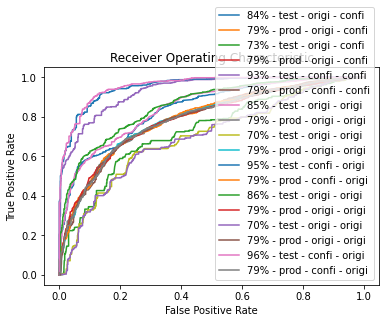

In [9]:
plt.figure()
data = []
for e in experiments:
    y_true = [1 if y==p else 0 for y,p in zip(e['y'], e['svc_pred'])]
    fpr, tpr, thresholds = roc_curve(y_true, e['pp_score'], pos_label=1)
    auc = roc_auc_score(y_true, e['pp_score'])
#     plt.plot(fpr, tpr, label=f'{auc:.2%} - {e["dataset"]}')
    plt.plot(fpr, tpr, label=f'{auc:.0%} - {e["dataset"]} - {",".join(e["svm_pointwise_features"])[:5]} - {",".join(e["mlp_pointwise_features"])[:5]}')


    acc, th, tl, fh, fl = check_correctness(e['y'],  e['svc_pred'],  e['pp_score'])
    data.append({'mlp pointwise features': e['mlp_pointwise_features'],
                 'svm pointwise features': e['svm_pointwise_features'],
                 'dataset': e['dataset'],
                 'pp data size': len(e['y']),
                 'fit dur min': e['fit_dur']/60,
                 'predict dur min': e['predict_dur']/60,
                 'svc accuracy': acc,
                 'pp accuracy': e['pp_accuracy'],
                 'TH': th,
                 'TL': tl,
                 'FH': fh,
                 'FL': fl,
                 'AUC': auc,
    })

pct_fmt = '{:,.2%}'.format
time_fmt = '{:,.1f}'.format
fmt = {col: pct_fmt for col in ['svc accuracy', 'pp accuracy', 'TH', 'TL', 'FH', 'FL', 'AUC']}
for p in ['fit', 'predict']:
    # for t in ['sec', 'min']:
    fmt[f'{p} dur min'] = time_fmt
display(HTML(pd.DataFrame(data).to_html(formatters=fmt)))

plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

,mlp pointwise features,svm pointwise features,dataset,pp data size,svc accuracy,pp accuracy,TH,TL,FH,FL,AUC
0,"[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",[original_features],prod,2000,63.60%,61.02%,0.65%,62.95%,0.00%,36.40%,79.22%
1,"[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]","[original_features, confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",prod,2000,63.60%,61.07%,0.10%,63.50%,0.10%,36.30%,79.04%
2,"[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]","[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",prod,2000,63.60%,61.19%,1.25%,62.35%,0.05%,36.35%,79.02%
3,[original_features],[original_features],prod,2000,63.60%,60.86%,0.00%,63.60%,0.00%,36.40%,78.89%
4,[original_features],"[original_features, confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",prod,2000,63.60%,60.89%,0.00%,63.60%,0.00%,36.40%,79.03%
5,[original_features],"[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",prod,2000,63.60%,61.00%,0.00%,63.60%,0.00%,36.40%,79.21%
6,"[original_features, confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",[original_features],prod,2000,63.60%,60.93%,0.00%,63.60%,0.00%,36.40%,78.86%
7,"[original_features, confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]","[original_features, confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",prod,2000,63.60%,60.98%,0.00%,63.60%,0.00%,36.40%,78.76%
8,"[original_features, confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]","[confidence_top, confidence_delta, confidence_entropy, class_frequency, mlp, svc, predicted_class, one_class_svm, pca]",prod,2000,63.60%,61.22%,0.00%,63.60%,0.00%,36.40%,78.85%


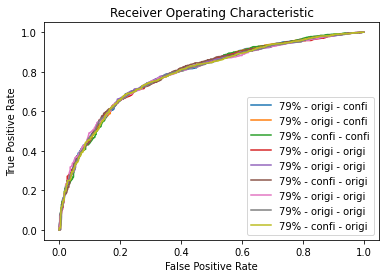

In [10]:
plt.figure()
data = []
for e in experiments:
    if e['dataset'] == 'prod':
        y_true = [1 if y==p else 0 for y,p in zip(e['y'], e['svc_pred'])]
        fpr, tpr, thresholds = roc_curve(y_true, e['pp_score'], pos_label=1)
        auc = roc_auc_score(y_true, e['pp_score'])
        plt.plot(fpr, tpr, label=f'{auc:.0%} - {",".join(e["svm_pointwise_features"])[:5]} - {",".join(e["mlp_pointwise_features"])[:5]}')

        acc, th, tl, fh, fl = check_correctness(e['y'],  e['svc_pred'],  e['pp_score'])
        data.append({'mlp pointwise features': e['mlp_pointwise_features'],
                     'svm pointwise features': e['svm_pointwise_features'],
                     'dataset': e['dataset'],
                     'pp data size': len(e['y']),
    #                  'fit dur min': e['fit_dur']/60,
    #                  'predict dur min': e['predict_dur']/60,
                     'svc accuracy': acc,
                     'pp accuracy': e['pp_accuracy'],
                     'TH': th,
                     'TL': tl,
                     'FH': fh,
                     'FL': fl,
                     'AUC': auc,
        })

pct_fmt = '{:,.2%}'.format
time_fmt = '{:,.1f}'.format
fmt = {col: pct_fmt for col in ['svc accuracy', 'pp accuracy', 'TH', 'TL', 'FH', 'FL', 'AUC']}
for p in ['fit', 'predict']:
    # for t in ['sec', 'min']:
    fmt[f'{p} dur min'] = time_fmt
display(HTML(pd.DataFrame(data).to_html(formatters=fmt)))

plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()